<a href="https://colab.research.google.com/github/ZarifAhmed14/yield-booster-bot/blob/main/hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import seaborn as sns
import matplotlib.pyplot as plt



In [6]:

print("🌾 Fertilizer & Irrigation Recommendation System - Training")
print("=" * 60)

🌾 Fertilizer & Irrigation Recommendation System - Training


In [4]:
print("\n📊 Loading dataset...")



📊 Loading dataset...


In [7]:
print("\n📊 Loading Kaggle dataset...")
print("\n⚠️ INSTRUCTIONS:")
print("1. Download dataset from: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset")
print("2. Upload 'Crop_recommendation.csv' to Colab using the file upload button")
print("3. Or use Kaggle API (instructions below)")
print("\n" + "=" * 60)


📊 Loading Kaggle dataset...

⚠️ INSTRUCTIONS:
1. Download dataset from: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset
2. Upload 'Crop_recommendation.csv' to Colab using the file upload button
3. Or use Kaggle API (instructions below)



In [8]:
print("\n📊 Loading Harvestify dataset...")

url = "https://raw.githubusercontent.com/Gladiator07/Harvestify/master/Data-processed/crop_recommendation.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully from Harvestify!")
    print(f"\n📈 Dataset shape: {df.shape}")
    print(f"\n📋 Columns: {list(df.columns)}")
    print(f"\n🌱 First few rows:")
    print(df.head())

    # Check for unique crops
    if 'label' in df.columns:
        print(f"\n🌾 Crops in dataset ({df['label'].nunique()} types):")
        print(df['label'].value_counts())

    # Display basic statistics
    print(f"\n📊 Dataset Statistics:")
    print(df.describe())

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    raise


📊 Loading Harvestify dataset...
✅ Dataset loaded successfully from Harvestify!

📈 Dataset shape: (2200, 8)

📋 Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

🌱 First few rows:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

🌾 Crops in dataset (22 types):
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        

In [9]:
print("\n" + "=" * 60)
print("🔧 Feature Engineering")
print("=" * 60)

# Encode crop labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['crop_encoded'] = le.fit_transform(df['label'])

print(f"\n✅ Encoded {len(le.classes_)} crop types:")
for idx, crop in enumerate(le.classes_):
    print(f"   {idx}: {crop}")

# Calculate soil moisture proxy from humidity and rainfall
# Formula: weighted combination of humidity and normalized rainfall
df['soil_moisture'] = (df['humidity'] * 0.65 + (df['rainfall'] / 4))
df['soil_moisture'] = df['soil_moisture'].clip(10, 100)  # Keep in realistic range

# Rename pH column for consistency
df = df.rename(columns={'ph': 'soil_ph'})

# Create fertilizer level labels based on NPK requirements
# This represents how much fertilizer the crop needs
def calculate_fertilizer_level(row):
    # NPK sum indicates nutrient demand
    npk_total = row['N'] + row['P'] + row['K']

    # Adjusted thresholds based on actual data distribution
    if npk_total < 120:
        return 0  # Low - crop needs less fertilizer
    elif npk_total < 180:
        return 1  # Medium - moderate fertilizer needs
    else:
        return 2  # High - crop needs more fertilizer

df['fertilizer_level'] = df.apply(calculate_fertilizer_level, axis=1)

# Create irrigation labels based on water requirements
def needs_irrigation(row):
    # Crops need irrigation if:
    # 1. Low rainfall AND low humidity, OR
    # 2. Low soil moisture, OR
    # 3. High temperature with insufficient water

    low_rainfall = row['rainfall'] < 100
    low_humidity = row['humidity'] < 50
    low_moisture = row['soil_moisture'] < 45
    high_temp_low_water = row['temperature'] > 30 and row['rainfall'] < 150

    if low_moisture or (low_rainfall and low_humidity) or high_temp_low_water:
        return 1  # Irrigation needed
    return 0  # No irrigation needed

df['irrigation_needed'] = df.apply(needs_irrigation, axis=1)

print("\n✅ Features created:")
print(f"   - Crop encoding: {len(le.classes_)} crops mapped to numeric values")
print(f"   - Soil moisture: calculated from humidity and rainfall")
print(f"\n📊 Fertilizer level distribution:")
print(df['fertilizer_level'].value_counts().sort_index())
print(f"\n💧 Irrigation distribution:")
print(df['irrigation_needed'].value_counts())

# Verify no missing values
print(f"\n🔍 Missing values check:")
print(df.isnull().sum())


🔧 Feature Engineering

✅ Encoded 22 crop types:
   0: apple
   1: banana
   2: blackgram
   3: chickpea
   4: coconut
   5: coffee
   6: cotton
   7: grapes
   8: jute
   9: kidneybeans
   10: lentil
   11: maize
   12: mango
   13: mothbeans
   14: mungbean
   15: muskmelon
   16: orange
   17: papaya
   18: pigeonpeas
   19: pomegranate
   20: rice
   21: watermelon

✅ Features created:
   - Crop encoding: 22 crops mapped to numeric values
   - Soil moisture: calculated from humidity and rainfall

📊 Fertilizer level distribution:
fertilizer_level
0    871
1    794
2    535
Name: count, dtype: int64

💧 Irrigation distribution:
irrigation_needed
0    1728
1     472
Name: count, dtype: int64

🔍 Missing values check:
N                    0
P                    0
K                    0
temperature          0
humidity             0
soil_ph              0
rainfall             0
label                0
crop_encoded         0
soil_moisture        0
fertilizer_level     0
irrigation_needed    

In [10]:
print("\n" + "=" * 60)
print("📚 Preparing Training Data")
print("=" * 60)

# Select features for model
feature_columns = ['crop_encoded', 'soil_ph', 'soil_moisture', 'temperature', 'rainfall']
X = df[feature_columns]
y_fertilizer = df['fertilizer_level']
y_irrigation = df['irrigation_needed']

print(f"\n📋 Feature columns used:")
for col in feature_columns:
    print(f"   - {col}: min={X[col].min():.2f}, max={X[col].max():.2f}, mean={X[col].mean():.2f}")

# Split data with stratification to maintain class distribution
X_train, X_test, y_fert_train, y_fert_test = train_test_split(
    X, y_fertilizer, test_size=0.2, random_state=42, stratify=y_fertilizer
)

_, _, y_irrig_train, y_irrig_test = train_test_split(
    X, y_irrigation, test_size=0.2, random_state=42, stratify=y_irrigation
)

print(f"\n✅ Data split complete:")
print(f"   Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")



📚 Preparing Training Data

📋 Feature columns used:
   - crop_encoded: min=0.00, max=21.00, mean=10.50
   - soil_ph: min=3.50, max=9.94, mean=6.47
   - soil_moisture: min=25.73, max=100.00, mean=71.20
   - temperature: min=8.83, max=43.68, mean=25.62
   - rainfall: min=20.21, max=298.56, mean=103.46

✅ Data split complete:
   Training samples: 1760 (80.0%)
   Test samples: 440 (20.0%)


In [11]:
print("\n" + "=" * 60)
print("🌿 Training Fertilizer Recommendation Model")
print("=" * 60)

fertilizer_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("\n⏳ Training in progress...")
fertilizer_model.fit(X_train, y_fert_train)
print("✅ Training complete!")

# Cross-validation for robust performance estimate
print("\n🔄 Running 5-fold cross-validation...")
cv_scores = cross_val_score(fertilizer_model, X_train, y_fert_train, cv=5, scoring='accuracy')
print(f"   CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# Evaluate on test set
y_fert_pred = fertilizer_model.predict(X_test)
fert_accuracy = accuracy_score(y_fert_test, y_fert_pred)

print(f"\n🎯 Test Set Performance:")
print(f"   Accuracy: {fert_accuracy:.3f} ({fert_accuracy*100:.1f}%)")
print("\n📊 Detailed Classification Report:")
print(classification_report(y_fert_test, y_fert_pred,
                          target_names=['Low', 'Medium', 'High'],
                          digits=3))

# Feature importance analysis
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': fertilizer_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Feature Importance (Fertilizer Model):")
for idx, row in importance_df.iterrows():
    print(f"   {row['feature']:15s}: {row['importance']:.4f} {'█' * int(row['importance']*50)}")



🌿 Training Fertilizer Recommendation Model

⏳ Training in progress...
✅ Training complete!

🔄 Running 5-fold cross-validation...
   CV Accuracy: 0.863 (+/- 0.018)

🎯 Test Set Performance:
   Accuracy: 0.816 (81.6%)

📊 Detailed Classification Report:
              precision    recall  f1-score   support

         Low      0.896     0.943     0.919       174
      Medium      0.741     0.755     0.748       159
        High      0.789     0.701     0.743       107

    accuracy                          0.816       440
   macro avg      0.809     0.799     0.803       440
weighted avg      0.814     0.816     0.814       440


🔍 Feature Importance (Fertilizer Model):
   crop_encoded   : 0.3607 ██████████████████
   soil_moisture  : 0.2092 ██████████
   rainfall       : 0.2020 ██████████
   soil_ph        : 0.1184 █████
   temperature    : 0.1096 █████


In [13]:
print("\n" + "=" * 60)
print("💧 Training Irrigation Recommendation Model")
print("=" * 60)

irrigation_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("\n⏳ Training in progress...")
irrigation_model.fit(X_train, y_irrig_train)
print("✅ Training complete!")

# Cross-validation
print("\n🔄 Running 5-fold cross-validation...")
cv_scores_irrig = cross_val_score(irrigation_model, X_train, y_irrig_train, cv=5, scoring='accuracy')
print(f"   CV Accuracy: {cv_scores_irrig.mean():.3f} (+/- {cv_scores_irrig.std()*2:.3f})")

# Evaluate
y_irrig_pred = irrigation_model.predict(X_test)
irrig_accuracy = accuracy_score(y_irrig_test, y_irrig_pred)

print(f"\n🎯 Test Set Performance:")
print(f"   Accuracy: {irrig_accuracy:.3f} ({irrig_accuracy*100:.1f}%)")
print("\n📊 Detailed Classification Report:")
print(classification_report(y_irrig_test, y_irrig_pred,
                          target_names=['No Irrigation', 'Irrigation Needed'],
                          digits=3))

# Feature importance
importance_df_irrig = pd.DataFrame({
    'feature': feature_columns,
    'importance': irrigation_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Feature Importance (Irrigation Model):")
for idx, row in importance_df_irrig.iterrows():
    print(f"   {row['feature']:15s}: {row['importance']:.4f} {'█' * int(row['importance']*50)}")



💧 Training Irrigation Recommendation Model

⏳ Training in progress...
✅ Training complete!

🔄 Running 5-fold cross-validation...
   CV Accuracy: 0.720 (+/- 0.020)

🎯 Test Set Performance:
   Accuracy: 0.716 (71.6%)

📊 Detailed Classification Report:
                   precision    recall  f1-score   support

    No Irrigation      0.784     0.882     0.830       346
Irrigation Needed      0.196     0.106     0.138        94

         accuracy                          0.716       440
        macro avg      0.490     0.494     0.484       440
     weighted avg      0.658     0.716     0.682       440


🔍 Feature Importance (Irrigation Model):
   temperature    : 0.2568 ████████████
   soil_ph        : 0.2525 ████████████
   rainfall       : 0.2289 ███████████
   soil_moisture  : 0.2034 ██████████
   crop_encoded   : 0.0584 ██



📈 Generating Visualizations
✅ Visualization saved as 'model_performance.png'
✅ Crop distribution saved as 'crop_distribution.png'


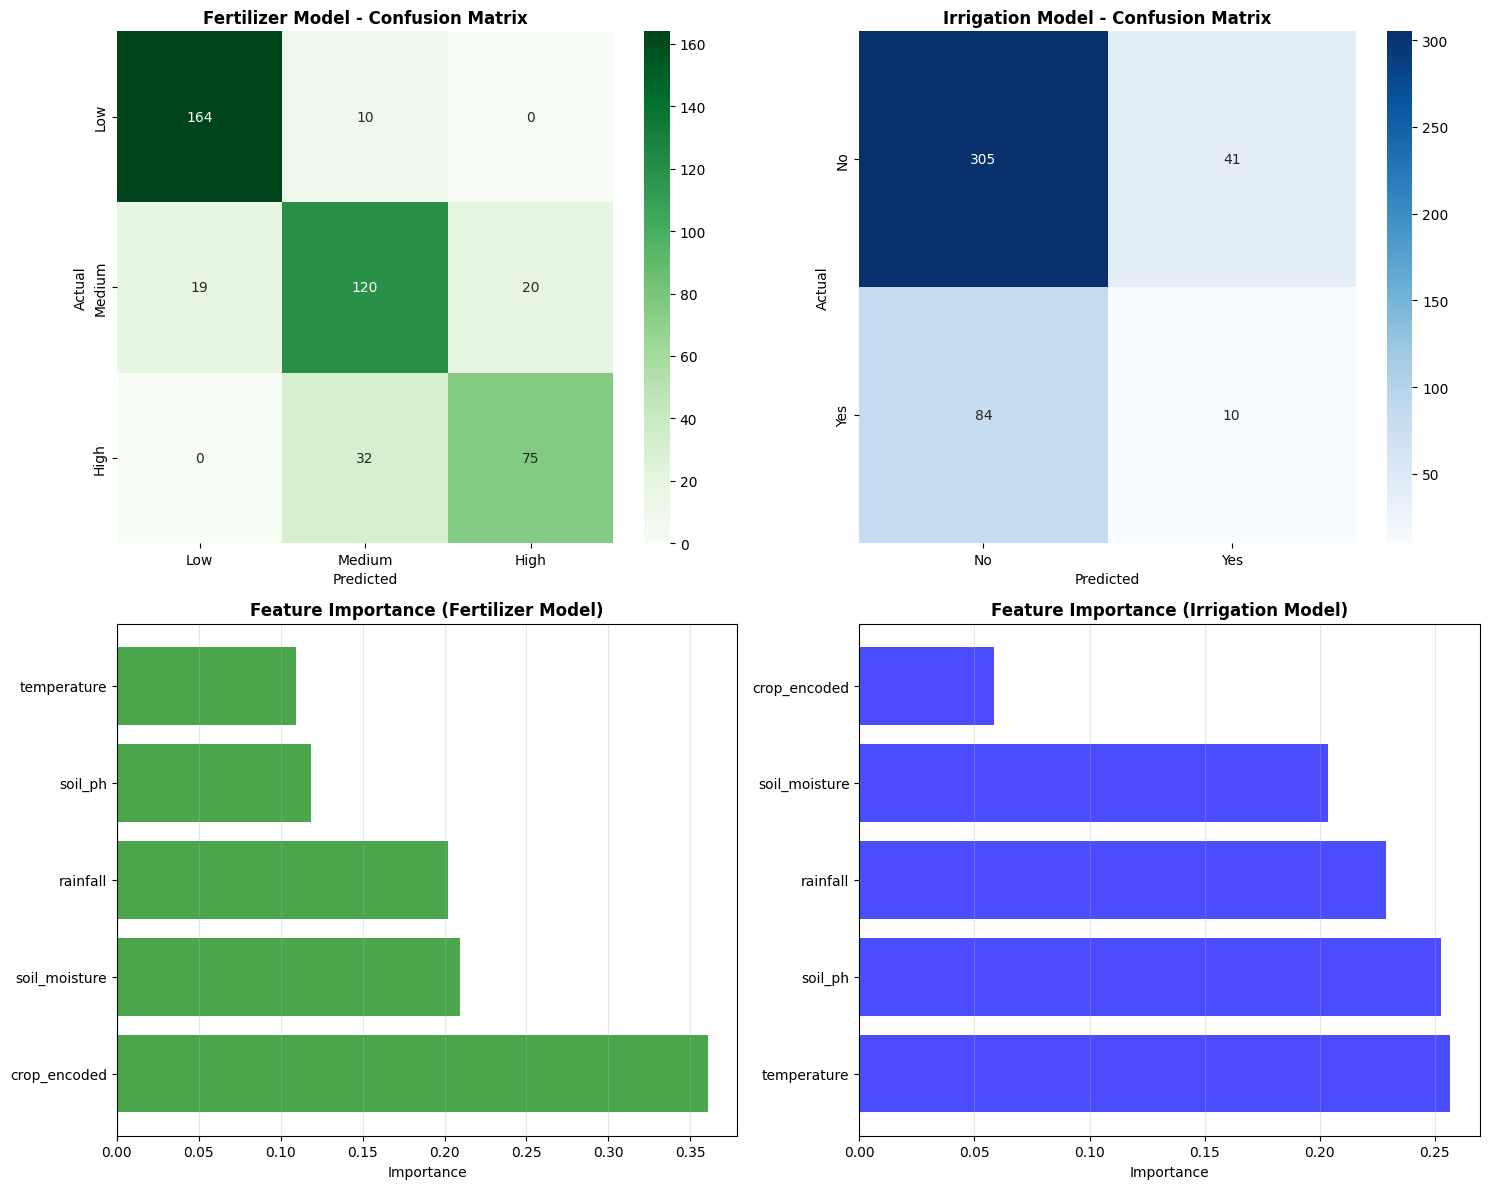

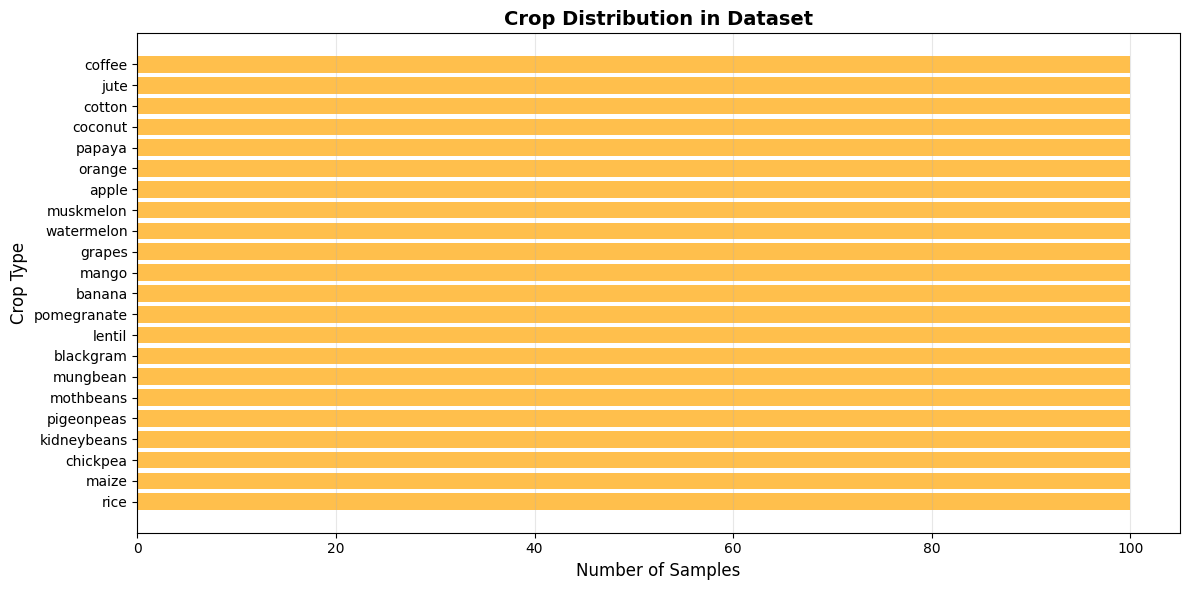

In [14]:
print("\n" + "=" * 60)
print("📈 Generating Visualizations")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix - Fertilizer
cm_fert = confusion_matrix(y_fert_test, y_fert_pred)
sns.heatmap(cm_fert, annot=True, fmt='d', cmap='Greens', ax=axes[0,0],
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
axes[0,0].set_title('Fertilizer Model - Confusion Matrix', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Predicted', fontsize=10)
axes[0,0].set_ylabel('Actual', fontsize=10)

# Confusion Matrix - Irrigation
cm_irrig = confusion_matrix(y_irrig_test, y_irrig_pred)
sns.heatmap(cm_irrig, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
axes[0,1].set_title('Irrigation Model - Confusion Matrix', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Predicted', fontsize=10)
axes[0,1].set_ylabel('Actual', fontsize=10)

# Feature Importance - Fertilizer
axes[1,0].barh(importance_df['feature'], importance_df['importance'], color='green', alpha=0.7)
axes[1,0].set_xlabel('Importance', fontsize=10)
axes[1,0].set_title('Feature Importance (Fertilizer Model)', fontsize=12, fontweight='bold')
axes[1,0].grid(axis='x', alpha=0.3)

# Feature Importance - Irrigation
axes[1,1].barh(importance_df_irrig['feature'], importance_df_irrig['importance'], color='blue', alpha=0.7)
axes[1,1].set_xlabel('Importance', fontsize=10)
axes[1,1].set_title('Feature Importance (Irrigation Model)', fontsize=12, fontweight='bold')
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'model_performance.png'")

# Additional visualization: Crop distribution
plt.figure(figsize=(12, 6))
crop_counts = df['label'].value_counts()
plt.barh(crop_counts.index, crop_counts.values, color='orange', alpha=0.7)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Crop Type', fontsize=12)
plt.title('Crop Distribution in Dataset', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('crop_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Crop distribution saved as 'crop_distribution.png'")

In [15]:
print("\n" + "=" * 60)
print("💾 Saving Models")
print("=" * 60)

joblib.dump(fertilizer_model, 'fertilizer_model.pkl')
joblib.dump(irrigation_model, 'irrigation_model.pkl')
joblib.dump(le, 'crop_encoder.pkl')

# Save comprehensive metadata
model_metadata = {
    'dataset_source': 'Harvestify Crop Recommendation Dataset',
    'dataset_url': 'https://github.com/Gladiator07/Harvestify',
    'total_samples': len(df),
    'n_crops': len(le.classes_),
    'crop_classes': le.classes_.tolist(),
    'feature_names': feature_columns,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'fertilizer_model': {
        'accuracy': float(fert_accuracy),
        'cv_mean': float(cv_scores.mean()),
        'cv_std': float(cv_scores.std()),
        'feature_importance': importance_df.set_index('feature')['importance'].to_dict()
    },
    'irrigation_model': {
        'accuracy': float(irrig_accuracy),
        'cv_mean': float(cv_scores_irrig.mean()),
        'cv_std': float(cv_scores_irrig.std()),
        'feature_importance': importance_df_irrig.set_index('feature')['importance'].to_dict()
    }
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("\n✅ All files saved successfully!")
print("\n📦 Files created:")
print("   ✓ fertilizer_model.pkl      (Fertilizer recommendation model)")
print("   ✓ irrigation_model.pkl      (Irrigation recommendation model)")
print("   ✓ crop_encoder.pkl          (Crop name encoder)")
print("   ✓ model_metadata.json       (Model statistics and info)")
print("   ✓ model_performance.png     (Performance visualizations)")
print("   ✓ crop_distribution.png     (Dataset crop distribution)")

# Step 8: Test Sample Predictions
print("\n" + "=" * 60)
print("🧪 Sample Predictions on Real Scenarios")
print("=" * 60)

# Test with actual crops from the dataset
test_cases = [
    {'crop': 'rice', 'soil_ph': 6.5, 'soil_moisture': 82, 'temperature': 24, 'rainfall': 202},
    {'crop': 'wheat', 'soil_ph': 6.8, 'soil_moisture': 45, 'temperature': 22, 'rainfall': 65},
    {'crop': 'maize', 'soil_ph': 6.2, 'soil_moisture': 62, 'temperature': 26, 'rainfall': 98},
    {'crop': 'cotton', 'soil_ph': 7.0, 'soil_moisture': 55, 'temperature': 28, 'rainfall': 75},
    {'crop': 'jute', 'soil_ph': 6.5, 'soil_moisture': 78, 'temperature': 27, 'rainfall': 180},
]

for i, test in enumerate(test_cases, 1):
    try:
        crop_enc = le.transform([test['crop']])[0]
        sample = pd.DataFrame([[
            crop_enc,
            test['soil_ph'],
            test['soil_moisture'],
            test['temperature'],
            test['rainfall']
        ]], columns=feature_columns)

        fert_pred = fertilizer_model.predict(sample)[0]
        fert_proba = fertilizer_model.predict_proba(sample)[0]
        irrig_pred = irrigation_model.predict(sample)[0]
        irrig_proba = irrigation_model.predict_proba(sample)[0]

        print(f"\n🌾 Test Case {i}: {test['crop'].upper()}")
        print(f"   Conditions: pH={test['soil_ph']}, Moisture={test['soil_moisture']}%, Temp={test['temperature']}°C, Rainfall={test['rainfall']}mm")
        print(f"   ├─ Fertilizer: {['Low', 'Medium', 'High'][fert_pred]} (confidence: {max(fert_proba):.1%})")
        print(f"   └─ Irrigation: {'✓ Needed' if irrig_pred else '✗ Not needed'} (confidence: {max(irrig_proba):.1%})")
    except ValueError:
        print(f"\n⚠️  Test Case {i}: Crop '{test['crop']}' not in training data")

print("\n" + "=" * 60)
print("🎉 Training Complete!")
print("=" * 60)
print(f"\n✨ Model Performance Summary:")
print(f"   • Fertilizer Model: {fert_accuracy:.1%} accuracy")
print(f"   • Irrigation Model: {irrig_accuracy:.1%} accuracy")
print(f"   • Trained on {len(df):,} samples across {len(le.classes_)} crops")
print(f"\n📥 Next Steps:")
print(f"   1. Download all .pkl files from Colab")
print(f"   2. Upload them to your FastAPI backend")
print(f"   3. Deploy and integrate with Lovable frontend")
print(f"\n🚀 Your ML models are ready for production!")


💾 Saving Models

✅ All files saved successfully!

📦 Files created:
   ✓ fertilizer_model.pkl      (Fertilizer recommendation model)
   ✓ irrigation_model.pkl      (Irrigation recommendation model)
   ✓ crop_encoder.pkl          (Crop name encoder)
   ✓ model_metadata.json       (Model statistics and info)
   ✓ model_performance.png     (Performance visualizations)
   ✓ crop_distribution.png     (Dataset crop distribution)

🧪 Sample Predictions on Real Scenarios

🌾 Test Case 1: RICE
   Conditions: pH=6.5, Moisture=82%, Temp=24°C, Rainfall=202mm
   ├─ Fertilizer: Medium (confidence: 51.8%)
   └─ Irrigation: ✗ Not needed (confidence: 76.5%)

⚠️  Test Case 2: Crop 'wheat' not in training data

🌾 Test Case 3: MAIZE
   Conditions: pH=6.2, Moisture=62%, Temp=26°C, Rainfall=98mm
   ├─ Fertilizer: Medium (confidence: 88.8%)
   └─ Irrigation: ✗ Not needed (confidence: 58.7%)

🌾 Test Case 4: COTTON
   Conditions: pH=7.0, Moisture=55%, Temp=28°C, Rainfall=75mm
   ├─ Fertilizer: Medium (confidence